In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asthma-disease-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5195233%2F8669080%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240622%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240622T015721Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d79aae63d9452df9f71fb186788d90208ba1d8dcb37ba67decf0062fc2e54e8fa59682e705534935904b68aea02b0b490fdbe7d7a515717c3226452b6e44b82327c0e0b8b44ee9fc3729b6acfb73d158bb53b051dc8fa4bbaf651f38444c318fa684fe8e1be5fa845cd2ce35defb762dae5abd7d1f6ac5af1b4a42eab23c92eb9c0e8c9c3ad22966eb392c66a66be3332b4a5131cbe859bd3a164ac66cc0d933d933bd3572344e8d5288d2ac65a28636cbfdb0935bd3f2c4a3dc70ec3765e965e823206cf2082b55399b3d7a7bfcf07c88d849b65ac17c5a017cba9a87026897f27b7c99c13a2c4b6ea11dba76f932d2452832cdee459931c5f11c177e0fef4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 227027 bytes downloaded
Downloaded and uncompressed: asthma-disease-dataset
Data source import complete.


In [2]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated*", category=FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/asthma-disease-dataset/asthma_disease_data.csv


In [3]:
# Load the data
data = pd.read_csv("/kaggle/input/asthma-disease-dataset/asthma_disease_data.csv")

In [4]:
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,...,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,...,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,...,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,...,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,...,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


# Fields and Data Types 🏥:
This table contains detailed patient information, demographic details, lifestyle factors, and medical history. It consists of the following columns:

* **PatientID**: A unique identifier assigned to each patient, ranging from 5034 to 7425.
* **Age**: The age of the patients, ranging from 5 to 80 years.
* **Gender**: Gender of the patients, where 0 represents Male and 1 represents Female.
* **Ethnicity**: The ethnicity of the patients, coded as follows: 0 for Caucasian, 1 for African American, 2 for Asian, and 3 for Other.
* **EducationLevel**: The education level of the patients, coded as follows: 0 for None, 1 for High School, 2 for Bachelor's, and 3 for Higher.

### Lifestyle Factors
* **BMI**: Body Mass Index of the patients, ranging from 15 to 40.
* **Smoking**: Smoking status, where 0 indicates No and 1 indicates Yes.
* **PhysicalActivity**: Weekly physical activity in hours, ranging from 0 to 10.
* **DietQuality**: Diet quality score, ranging from 0 to 10.
* **SleepQuality**: Sleep quality score, ranging from 4 to 10.

### Environmental and Allergy Factors
* **PollutionExposure**: Exposure to pollution, scored from 0 to 10.
* **PollenExposure**: Exposure to pollen, scored from 0 to 10.
* **DustExposure**: Exposure to dust, scored from 0 to 10.
* **PetAllergy**: Pet allergy status, where 0 indicates No and 1 indicates Yes.

### Medical History
* **FamilyHistoryAsthma**: Family history of asthma, where 0 indicates No and 1 indicates Yes.
* **HistoryOfAllergies**: History of allergies, where 0 indicates No and 1 indicates Yes.
* **Eczema**: Presence of eczema, where 0 indicates No and 1 indicates Yes.
* **HayFever**: Presence of hay fever, where 0 indicates No and 1 indicates Yes.
* **GastroesophagealReflux**: Presence of gastroesophageal reflux, where 0 indicates No and 1 indicates Yes.

### Clinical Measurements
* **LungFunctionFEV1**: Forced Expiratory Volume in 1 second (FEV1), ranging from 1.0 to 4.0 liters.
* **LungFunctionFVC**: Forced Vital Capacity (FVC), ranging from 1.5 to 6.0 liters.

### Symptoms
* **Wheezing**: Presence of wheezing, where 0 indicates No and 1 indicates Yes.
* **ShortnessOfBreath**: Presence of shortness of breath, where 0 indicates No and 1 indicates Yes.
* **ChestTightness**: Presence of chest tightness, where 0 indicates No and 1 indicates Yes.
* **Coughing**: Presence of coughing, where 0 indicates No and 1 indicates Yes.
* **NighttimeSymptoms**: Presence of nighttime symptoms, where 0 indicates No and 1 indicates Yes.
* **ExerciseInduced**: Presence of symptoms induced by exercise, where 0 indicates No and 1 indicates Yes.

### Diagnosis Information
* **Diagnosis**: Diagnosis status for Asthma, where 0 indicates No and 1 indicates Yes.

### Confidential Information
* **DoctorInCharge**: Contains confidential information about the doctor in charge, with "Dr_Confid" as the value for all patients.

In [5]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               2392 non-null   int64  
 1   Age                     2392 non-null   int64  
 2   Gender                  2392 non-null   int64  
 3   Ethnicity               2392 non-null   int64  
 4   EducationLevel          2392 non-null   int64  
 5   BMI                     2392 non-null   float64
 6   Smoking                 2392 non-null   int64  
 7   PhysicalActivity        2392 non-null   float64
 8   DietQuality             2392 non-null   float64
 9   SleepQuality            2392 non-null   float64
 10  PollutionExposure       2392 non-null   float64
 11  PollenExposure          2392 non-null   float64
 12  DustExposure            2392 non-null   float64
 13  PetAllergy              2392 non-null   int64  
 14  FamilyHistoryAsthma     2392 non-null   

In [6]:
# Descriptive statistics
data.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,...,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,6229.500000,42.137960,0.493311,0.669732,1.307274,27.244877,0.141722,5.051786,5.022867,7.019012,...,0.158027,2.548564,3.741270,0.596154,0.500418,0.503344,0.503344,0.602425,0.604933,0.051839
std,690.655244,21.606655,0.500060,0.986120,0.898242,7.201628,0.348838,2.903574,2.909980,1.732475,...,0.364842,0.861809,1.303689,0.490770,0.500104,0.500093,0.500093,0.489499,0.488967,0.221749
min,5034.000000,5.000000,0.000000,0.000000,0.000000,15.031803,0.000000,0.001740,0.003031,4.001437,...,0.000000,1.000459,1.500045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5631.750000,23.000000,0.000000,0.000000,1.000000,20.968313,0.000000,2.578333,2.432043,5.498500,...,0.000000,1.824113,2.607489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6229.500000,42.000000,0.000000,0.000000,1.000000,27.052202,0.000000,5.016881,5.115383,6.975839,...,0.000000,2.553244,3.734982,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,6827.250000,61.000000,1.000000,1.000000,2.000000,33.555903,0.000000,7.540234,7.544216,8.526950,...,0.000000,3.292897,4.864121,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,7425.000000,79.000000,1.000000,3.000000,3.000000,39.985611,1.000000,9.995809,9.999904,9.996235,...,1.000000,3.999719,5.999421,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Display column names
data.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy',
       'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever',
       'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC',
       'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing',
       'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

# Handling missing data

In [8]:
# Missing data
print(data.isnull().sum())

PatientID                 0
Age                       0
Gender                    0
Ethnicity                 0
EducationLevel            0
BMI                       0
Smoking                   0
PhysicalActivity          0
DietQuality               0
SleepQuality              0
PollutionExposure         0
PollenExposure            0
DustExposure              0
PetAllergy                0
FamilyHistoryAsthma       0
HistoryOfAllergies        0
Eczema                    0
HayFever                  0
GastroesophagealReflux    0
LungFunctionFEV1          0
LungFunctionFVC           0
Wheezing                  0
ShortnessOfBreath         0
ChestTightness            0
Coughing                  0
NighttimeSymptoms         0
ExerciseInduced           0
Diagnosis                 0
DoctorInCharge            0
dtype: int64


# EDA (Exploratory Data Analysis)

In [9]:
# Select numerical columns
numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns

# Print all numerical data
print([numerical_columns])

[Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy',
       'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever',
       'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC',
       'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing',
       'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis'],
      dtype='object')]


<ipython-input-10-5b5feee1e78d>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


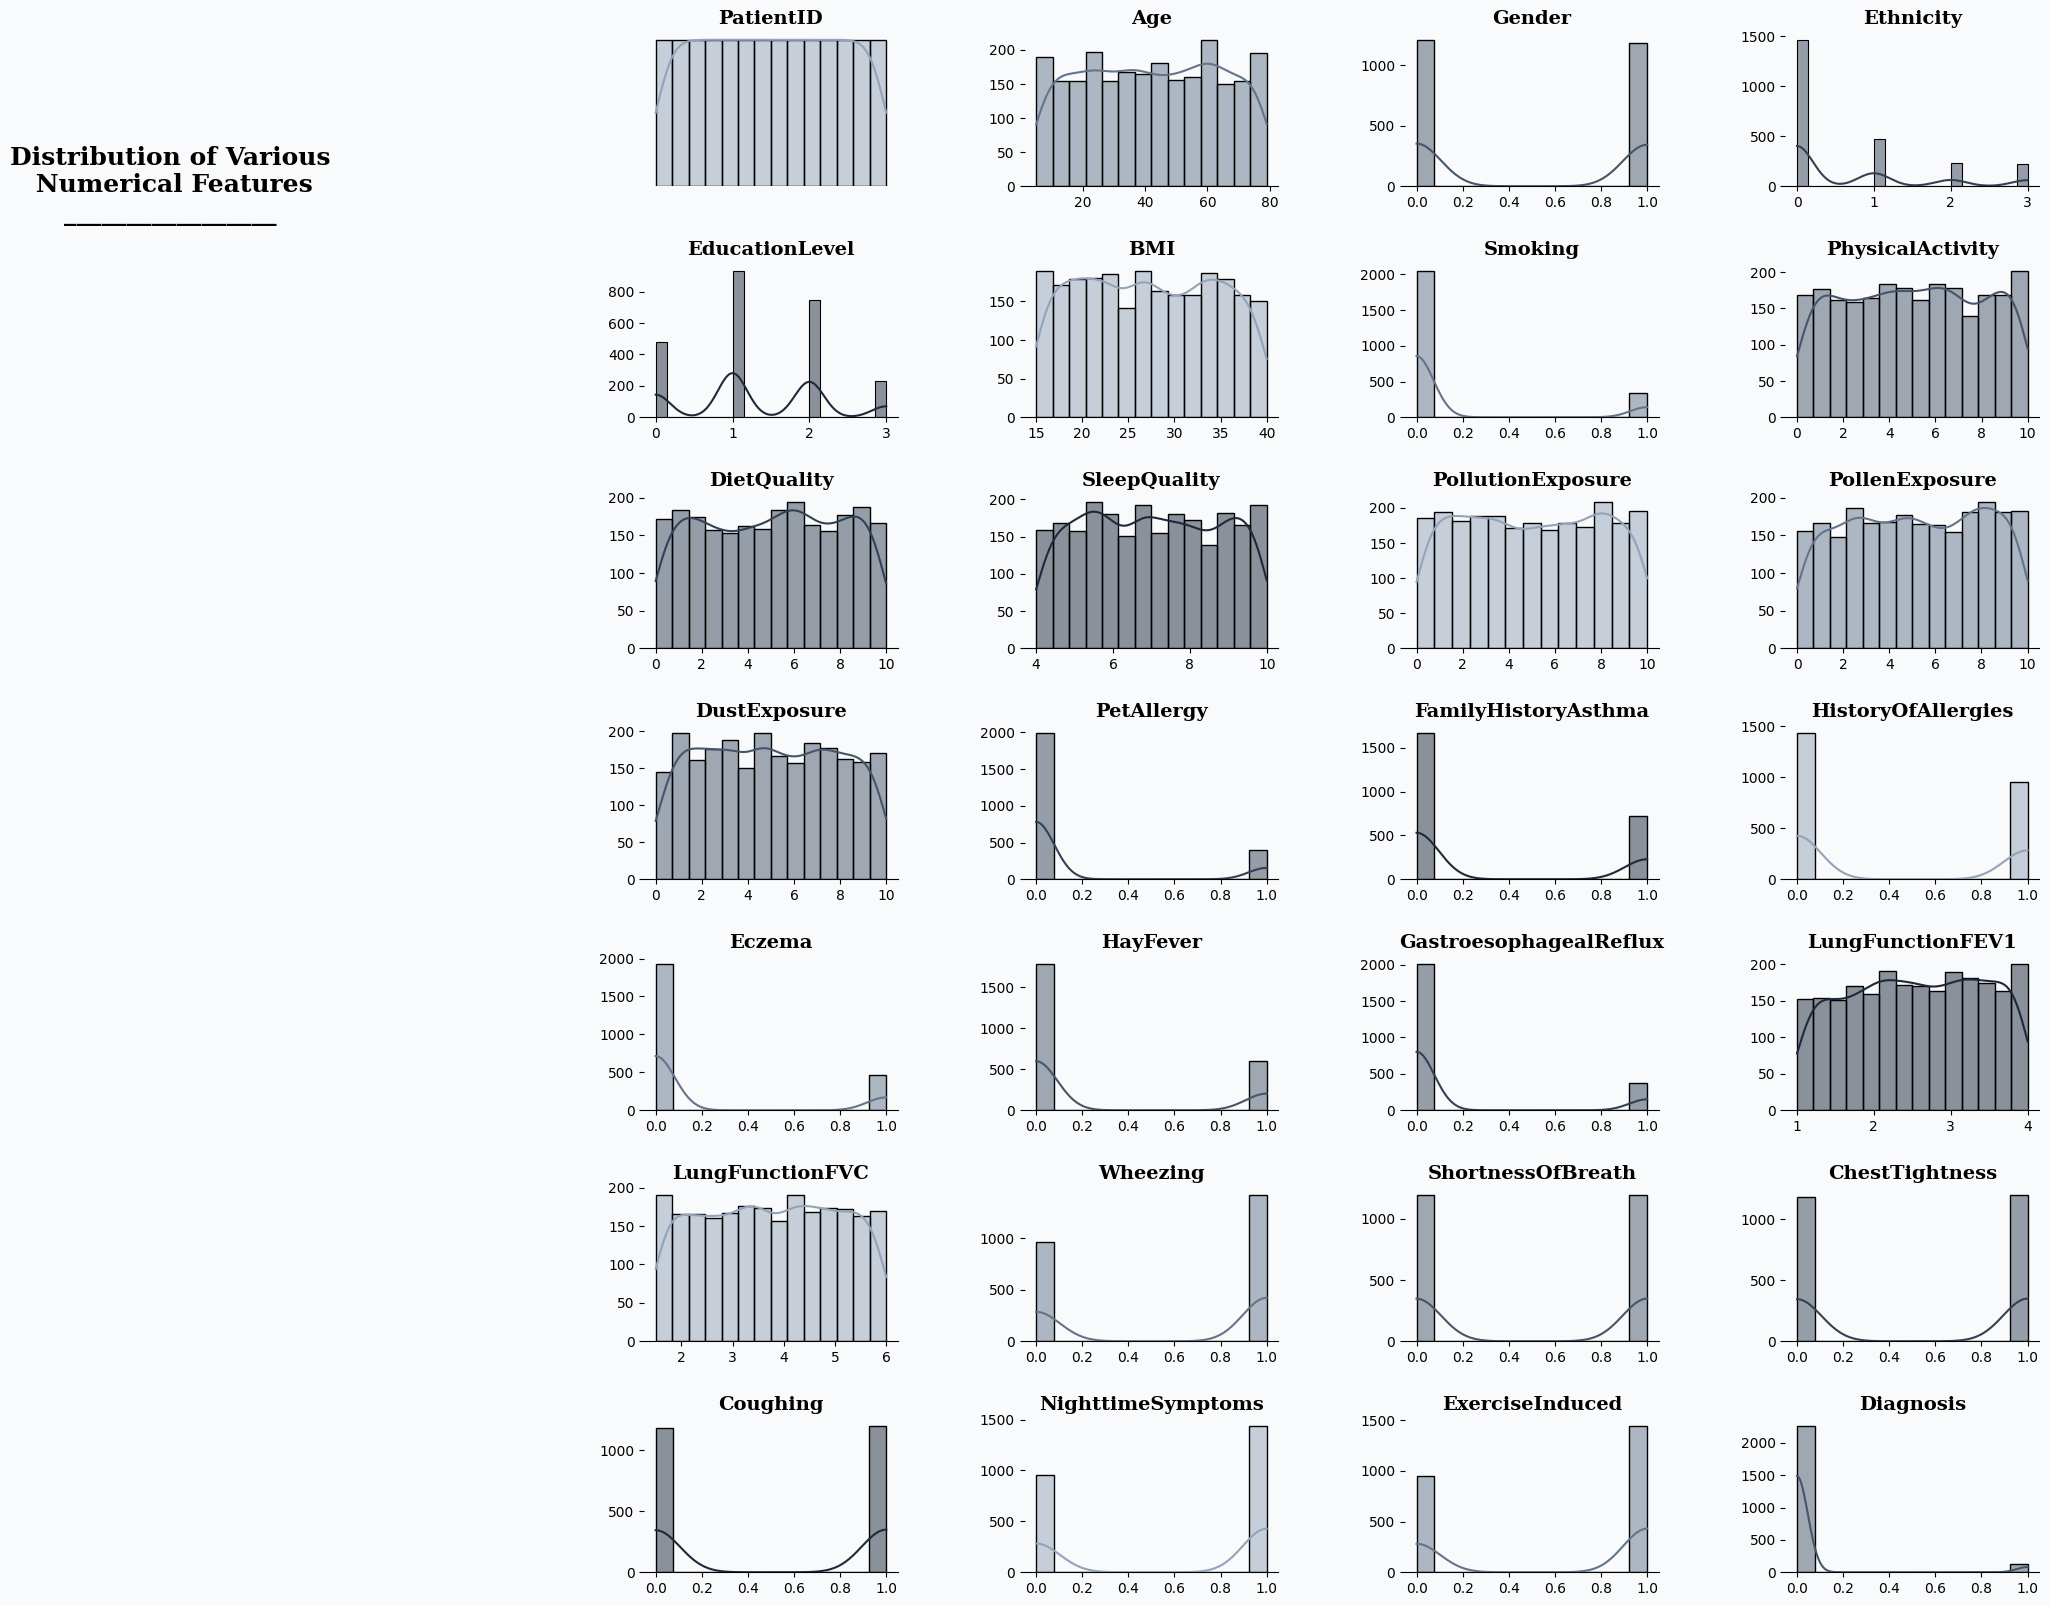

In [10]:
# Plot distributions for numerical features
fig = plt.figure(figsize=(18, 20))
gs = fig.add_gridspec(7, 4)
gs.update(wspace=0.5, hspace=0.5)
axes = []

background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)

for i in range(7):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
            'Distribution of Various\n Numerical Features\n_________________',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=18, fontweight='bold',
            fontfamily='serif',
            color="#000000")

# Plot histograms for each numerical column
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(data[col], kde=True, ax=ax, color=color_palette[i % len(color_palette)])
    ax.set_title(col, fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in axes[1:]:
    for s in ["top", "right", "left"]:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

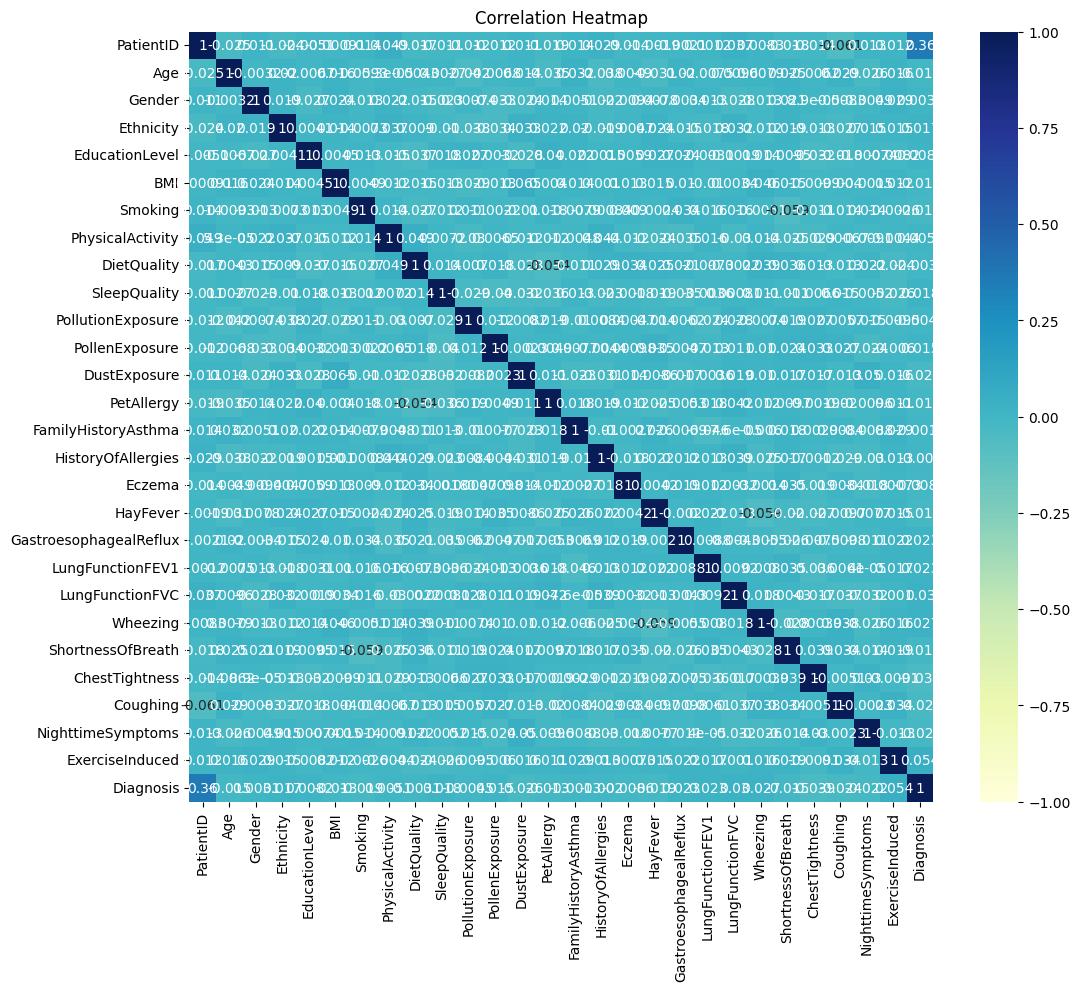

In [11]:
# Filter DataFrame by numerical columns
numeric_data = data[numerical_columns]

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Analysis Patient

In [12]:
# Data filtering
age_diagnosed = data[data['Diagnosis'] == 1]['Age']
age_not_diagnosed = data[data['Diagnosis'] == 0]['Age']

print("Ages of diagnosed patients:")
print(age_diagnosed.values)

print("\nAges of not diagnosed patients:")
print(age_not_diagnosed.values)

Ages of diagnosed patients:
[31 45 69 49 60  5 49 32 21 48 77 42 79 61 20 58 47 70 77 32  9 26 30 67
 13 24 40 16 12 12  5  5 23 40 22 63 36 67 23 58  7 51 43 25 14 31 35 56
 49 45 62  7 41 72 63 65  7 39 18 39 16 61  6 69 17 41 39 38 36 74 19 61
 16 73  6 15 56 12 63 45 74 78 60 55 68 16 41 76 28 53 23 18 78 67 65 35
 13 25 20 37 36  5 24 78 77 26 54 58 56 35 68 27 12 70 77 25  5  9 74 65
 31 43 18 54]

Ages of not diagnosed patients:
[63 26 57 ...  5 46 26]


In [13]:
# Max and min age diagnosed
max_age_diagnosed = age_diagnosed.max()
min_age_diagnosed = age_diagnosed.min()

max_age_count_diagnosed = age_diagnosed.value_counts().max()
min_age_count_diagnosed = age_diagnosed.value_counts().min()

# Mean and std age diagnosed
mean_age_diagnosed = age_diagnosed.mean()
std_age_diagnosed = age_diagnosed.std()

mean_age_not_diagnosed = age_not_diagnosed.mean()
std_age_not_diagnosed = age_not_diagnosed.std()


print("Descriptive Statistics:")
print(f"Maximum age diagnosed: {max_age_diagnosed}")
print(f"Minimum age diagnosed: {min_age_diagnosed}")

print(f"Maximum age count diagnosed: {max_age_count_diagnosed}")
print(f"Minimum age count diagnosed: {min_age_count_diagnosed}")

print(f"Mean age (diagnosed): {mean_age_diagnosed:.2f} ± {std_age_diagnosed:.2f}")
print(f"Mean age (not diagnosed): {mean_age_not_diagnosed:.2f} ± {std_age_not_diagnosed:.2f}")

Descriptive Statistics:
Maximum age diagnosed: 79
Minimum age diagnosed: 5
Maximum age count diagnosed: 5
Minimum age count diagnosed: 1
Mean age (diagnosed): 40.74 ± 22.75
Mean age (not diagnosed): 42.21 ± 21.55


In [14]:
# Function to create pie charts
def pie_chart(labels, values, title):
    # Create a color palette based on ocean colors
    sns.color_palette("ocean")

    # Set the color palette
    color_palette = sns.color_palette()

    # Set the style of the plot
    sns.set_style("white")
    plt.rcParams['font.family'] = 'serif'

    # Create the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, colors=color_palette, autopct="%1.1f%%")

    # Add title and legend
    plt.title(title, fontdict={'fontweight': 'bold', 'fontsize': 16})
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()


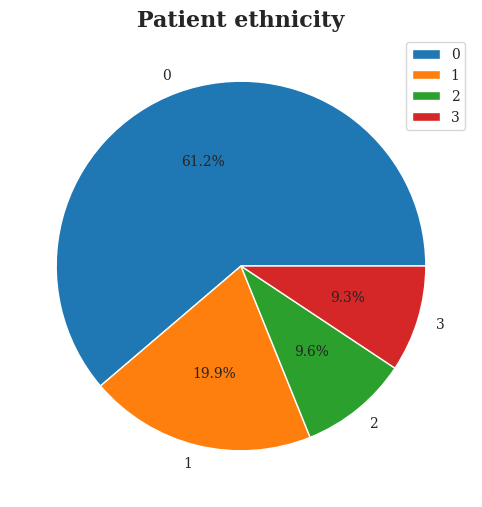

In [15]:
# Plot pie chart for patient ethnicity
pie_chart(data['Ethnicity'].value_counts().index, data['Ethnicity'].value_counts().values, 'Patient ethnicity')

In [16]:
# Frequency and percentage of each ethnicity by diagnosis status
ethnicity_diagnosis_counts = pd.crosstab(data['Ethnicity'], data['Diagnosis'])
ethnicity_diagnosis_percentage = ethnicity_diagnosis_counts.apply(lambda r: r/r.sum()*100, axis=1)

print("\n0: Caucasian,\n1: African American,\n2: Asian,\n3: Other")

print("\nFrequency of each ethnicity by diagnosis status:")
print(ethnicity_diagnosis_counts)

print("\nPercentage of each ethnicity by diagnosis status:")
print(ethnicity_diagnosis_percentage)


0: Caucasian,
1: African American,
2: Asian,
3: Other

Frequency of each ethnicity by diagnosis status:
Diagnosis     0   1
Ethnicity          
0          1392  73
1           450  25
2           218  11
3           208  15

Percentage of each ethnicity by diagnosis status:
Diagnosis          0         1
Ethnicity                     
0          95.017065  4.982935
1          94.736842  5.263158
2          95.196507  4.803493
3          93.273543  6.726457


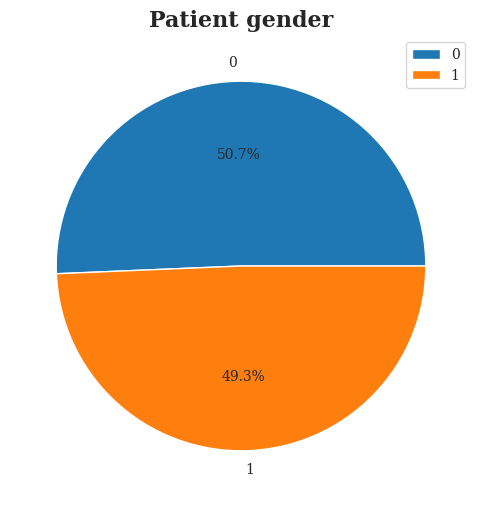

In [17]:
# Plot pie chart for patient gender
pie_chart(data['Gender'].value_counts().index, data['Gender'].value_counts().values, 'Patient gender')

In [18]:
# Frequency and percentage of each gender by diagnosis status
years_dignosis_count = pd.crosstab(data['Gender'], data['Diagnosis'])
years_dignosis_percentage = years_dignosis_count.apply(lambda r: r/r.sum()*100, axis=1)

print("\n0: Male \n1: Female")

print("\nFrequency of each year by diagnosis status:")
print(years_dignosis_count)

print("\nPercentage of each year by diagnosis status:")
print(years_dignosis_percentage)


0: Male 
1: Female

Frequency of each year by diagnosis status:
Diagnosis     0   1
Gender             
0          1150  62
1          1118  62

Percentage of each year by diagnosis status:
Diagnosis          0         1
Gender                        
0          94.884488  5.115512
1          94.745763  5.254237


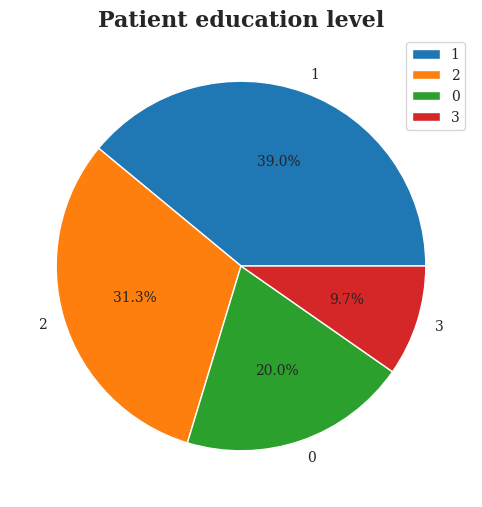

In [19]:
# Plot pie chart for patient education level
pie_chart(data['EducationLevel'].value_counts().index, data['EducationLevel'].value_counts().values, 'Patient education level')

In [20]:
# Frequency and percentage of each education level by diagnosis status
education_diagnosis_counts = pd.crosstab(data['EducationLevel'], data['Diagnosis'])
education_diagnosis_percentage = education_diagnosis_counts.apply(lambda r: r/r.sum()*100, axis=1)

print("\n0: None \n1: High School \n2: Bachelor's \n3: Higher")

print("\nFrequency of each education level by diagnosis status:")
print(education_diagnosis_counts)

print("\nPercentage of each education level by diagnosis status:")
print(education_diagnosis_percentage)


0: None 
1: High School 
2: Bachelor's 
3: Higher

Frequency of each education level by diagnosis status:
Diagnosis         0   1
EducationLevel         
0               453  25
1               882  51
2               720  29
3               213  19

Percentage of each education level by diagnosis status:
Diagnosis               0         1
EducationLevel                     
0               94.769874  5.230126
1               94.533762  5.466238
2               96.128171  3.871829
3               91.810345  8.189655


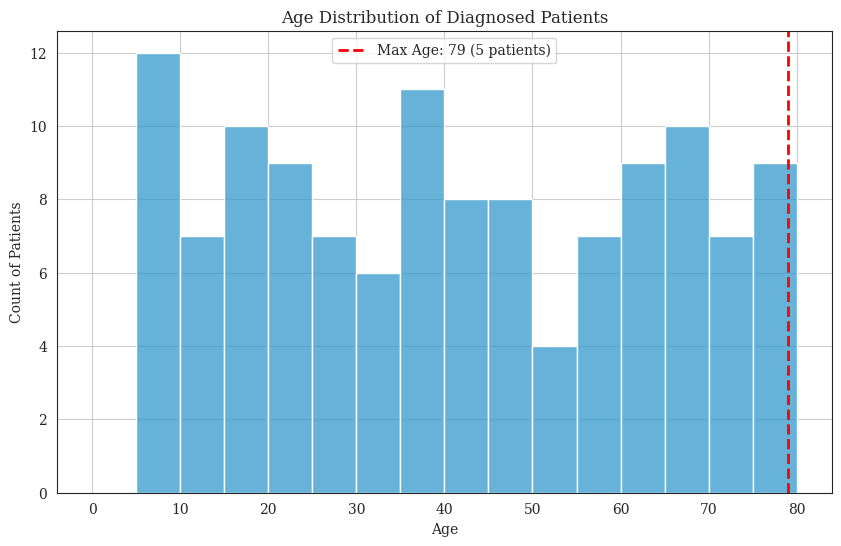

In [21]:
# Plot histogram for age distribution of diagnosed patients
plt.figure(figsize=(10, 6))
sns.histplot(age_diagnosed, bins=range(0, 85, 5), kde=False, color=(0.2, 0.6, 0.8))
plt.axvline(max_age_diagnosed, color='red', linestyle='--', linewidth=2, label=f'Max Age: {max_age_diagnosed} ({max_age_count_diagnosed} patients)')
plt.title('Age Distribution of Diagnosed Patients')
plt.xlabel('Age')
plt.ylabel('Count of Patients')
plt.legend()
plt.grid(True)

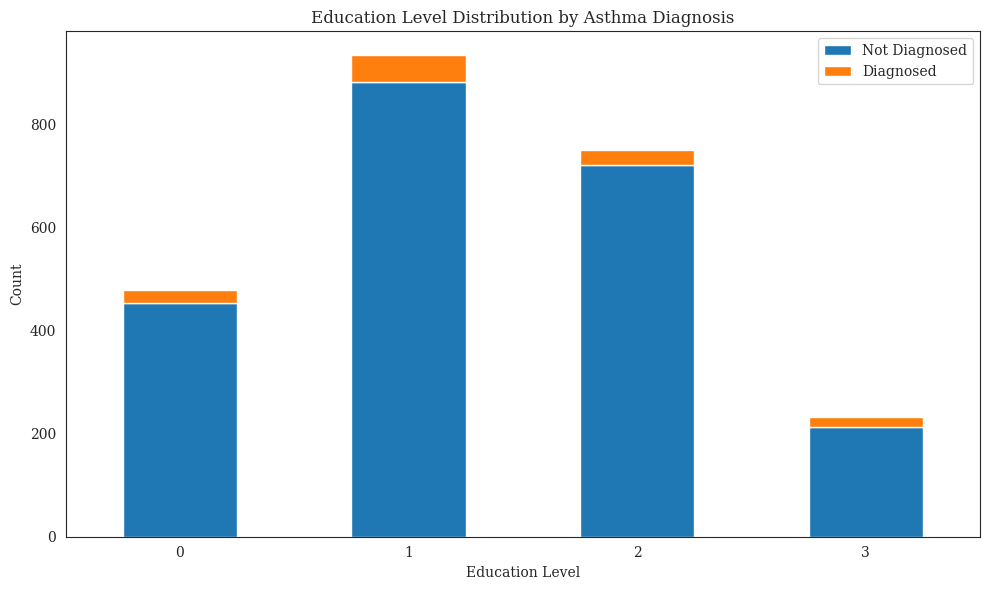

In [22]:
# Plot bar chart for education level distribution by asthma diagnosis
education_diagnosis_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Education Level Distribution by Asthma Diagnosis')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Not Diagnosed', 'Diagnosed'])

plt.tight_layout()
plt.show()

# Drop "PatientID" and "DoctorInCharge"

In [23]:
data.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

In [24]:
# Split the data into features (X) and target (y)
X = data.drop(['Diagnosis'], axis=1)
y = data['Diagnosis']

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Initialize some models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'XGBoost': XGBClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [28]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
    print("\n")

Model: Logistic Regression
Accuracy: 0.9519832985386222
ROC AUC: 0.5225972540045767


Model: Random Forest
Accuracy: 0.9519832985386222
ROC AUC: 0.3763825324180015


Model: Gradient Boosting
Accuracy: 0.9498956158663883
ROC AUC: 0.4391685736079329


Model: Support Vector Machine
Accuracy: 0.9519832985386222
ROC AUC: 0.5078184591914569


Model: XGBoost
Accuracy: 0.9519832985386222
ROC AUC: 0.4032227307398932


Model: K-Nearest Neighbors
Accuracy: 0.9519832985386222
ROC AUC: 0.5416666666666666


